In [1]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 2.0.1+cu118
CUDA version: 11.8
cuDNN version: 8700


In [3]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

## 1) This function extracts each frame from the input video

In [4]:
def extract_frames(video_loc, saving_frames_loc):

    cam = cv2.VideoCapture(video_loc)
    frame_num = 0
    filenames = []

    while (True):
        ret, frame = cam.read()
        if ret:
            zero_num = 10
            tmp = frame_num
            while tmp > 0:
                tmp = int(tmp / 10)
                zero_num -= 1
            zeros = ""
            for i in range(zero_num):
                zeros = str(0) + zeros
            name = saving_frames_loc + '/' + zeros + str(frame_num) + '.jpg'
            cv2.imwrite(name, frame)
            frame_num += 1
            filenames.append(name)
        else:
            break

    cam.release()
    cv2.destroyAllWindows()
    return filenames

## 2) Face Detection

Helper code for making plots:

In [5]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)

    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])

    for i in range(detections.shape[0]):
        ymin = detections[i, 0] * img.shape[0]
        xmin = detections[i, 1] * img.shape[1]
        ymax = detections[i, 2] * img.shape[0]
        xmax = detections[i, 3] * img.shape[1]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none",
                                 alpha=detections[i, 16])
        ax.add_patch(rect)

        if with_keypoints:
            for k in range(6):
                kp_x = detections[i, 4 + k*2    ] * img.shape[1]
                kp_y = detections[i, 4 + k*2 + 1] * img.shape[0]
                circle = patches.Circle((kp_x, kp_y), radius=0.5, linewidth=1,
                                        edgecolor="lightskyblue", facecolor="none",
                                        alpha=detections[i, 16])
                ax.add_patch(circle)

    plt.show()

## Load the back model of BlazeFace

In [6]:
from face_detection.blazeface import BlazeFace

back_net = BlazeFace(back_model=True).to(gpu)
back_net.load_weights("face_detection/blazefaceback.pth")
back_net.load_anchors("face_detection/anchorsback.npy")

In [7]:
video_loc = "face_detection/sample_data/Sample_video.mkv"
frames_loc = "face_detection/sample_data/frames"

files = extract_frames(video_loc, frames_loc)

xback = np.zeros((len(files), 256, 256, 3), dtype=np.uint8)

for i, filename in enumerate(files):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    xback[i] = cv2.resize(img, (256, 256))

back_detections = back_net.predict_on_batch(xback)

Found 1 faces


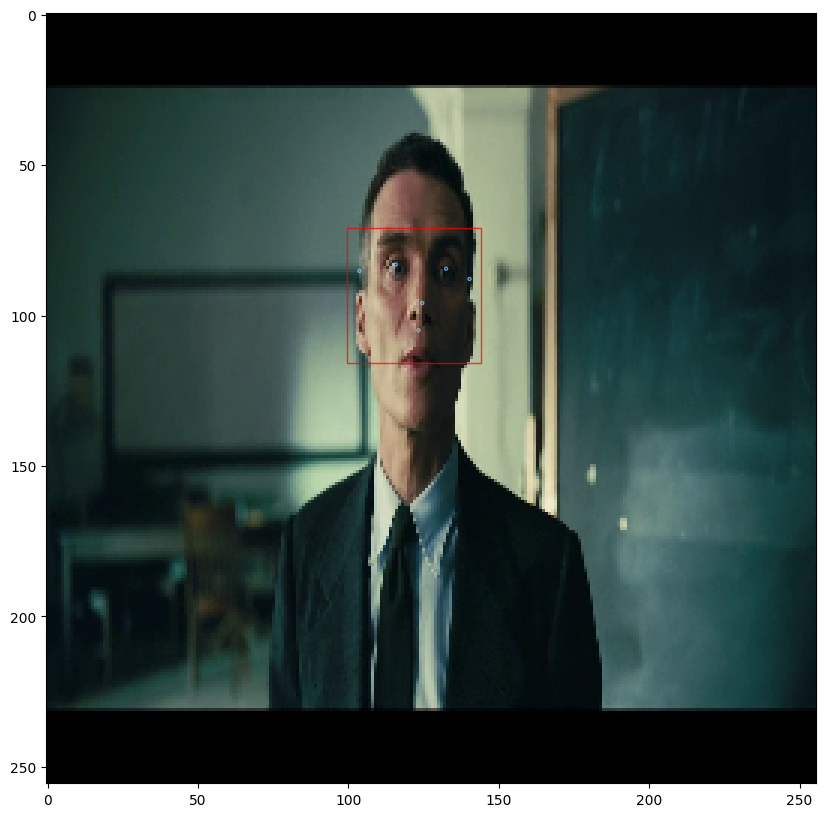

In [8]:
plot_detections(xback[20], back_detections[20])

## 3) Face Landmark Detection

Using mediapipe for detecting face landmarks

In [9]:
import mediapipe as mp

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

def detect_face_landmarks(image):

    results = face_mesh.process(image)
    if not results.multi_face_landmarks:
        return None
    landmarks = results.multi_face_landmarks[0]
    return landmarks

def plot_face_landmarks(image, landmarks):
    
    img_height, img_width, _ = image.shape
    for landmark in landmarks.landmark:
        x = int(landmark.x * img_width)
        y = int(landmark.y * img_height)
        cv2.circle(image, (x, y), 1, (0, 255, 0), -1)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.show()

In [10]:
input_imgs = []
landmarks = []

# for i, img in enumerate(xback):
#     if len(back_detections[i]) > 0:
#         lm = detect_face_landmarks(img)
#         input_imgs.append(img)
#         landmarks.append(lm)
    
for i, file in enumerate(files):
    if len(back_detections[i]) > 0:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        lm = detect_face_landmarks(img)
        input_imgs.append(img)
        landmarks.append(lm)

c:\Users\Mojtaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


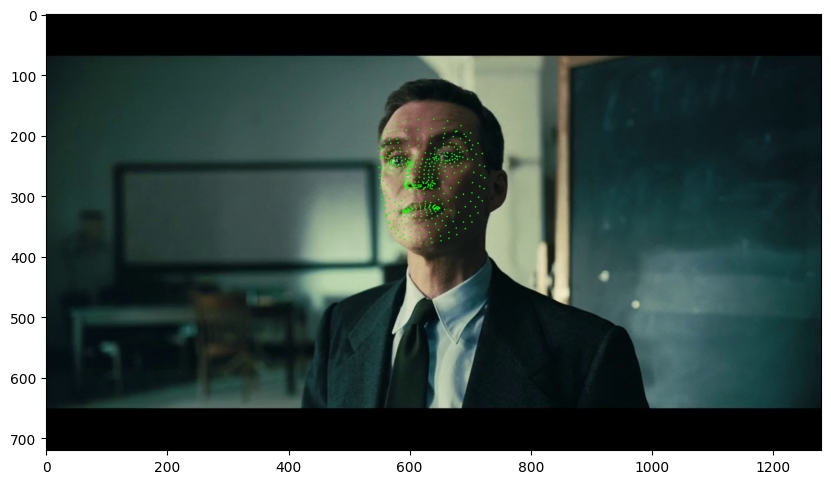

In [11]:
plot_face_landmarks(input_imgs[0], landmarks[0])

## 4) Face Alignment

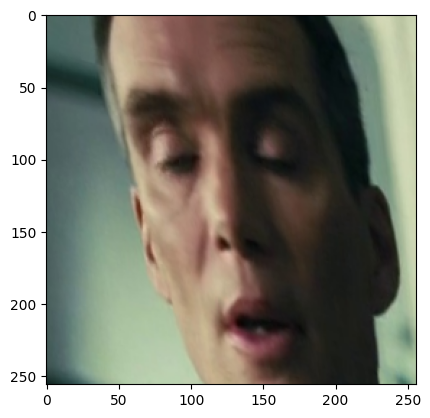

In [12]:
def align_face(image, landmarks, target_size=(256, 256)):

    target_points = np.array([
        [0.3 * target_size[0], 0.4 * target_size[1]],
        [0.7 * target_size[0], 0.4 * target_size[1]],
        [0.5 * target_size[0], 0.6 * target_size[1]],
        [0.5 * target_size[0], 0.75 * target_size[1]]
    ], dtype=np.float32)
    
    landmark_points = np.array([
        [landmarks.landmark[33].x * image.shape[1], 
         landmarks.landmark[33].y * image.shape[0]], 
        [landmarks.landmark[263].x * image.shape[1],
         landmarks.landmark[263].y * image.shape[0]],
        [landmarks.landmark[1].x * image.shape[1], 
         landmarks.landmark[1].y * image.shape[0]],  
        [(landmarks.landmark[13].x + landmarks.landmark[14].x) / 2 * image.shape[1], 
         (landmarks.landmark[13].y + landmarks.landmark[14].y) / 2 * image.shape[0]]
    ], dtype=np.float32)
    
    transformation_matrix = cv2.getAffineTransform(landmark_points[:3], target_points[:3])
    
    aligned_face = cv2.warpAffine(image, transformation_matrix, target_size)
    
    return aligned_face

aligned_faces = []
for i in range(len(input_imgs)):
    af = align_face(input_imgs[i], landmarks[i])
    aligned_faces.append(af)

# plt.figure(figsize=(5, 5))
plt.imshow(aligned_faces[30])
plt.show()


## 5) Face embedding and Recognition

In [13]:
from ellzaf_ml.models import GhostFaceNetsV2

IMAGE_SIZE = 112

ghostface_model = GhostFaceNetsV2(image_size=IMAGE_SIZE, width=1, dropout=0.)
ghostface_model.eval()

def recognize_faces(aligned_faces):
    """Recognize faces using GhostFaceNets."""
    embeddings = []
    with torch.no_grad():
        for face in aligned_faces:
            face_tensor = torch.from_numpy(face).permute(2, 0, 1).unsqueeze(0).float() / 255.0  # Convert image to torch tensor
            face_tensor = torch.nn.functional.interpolate(face_tensor, size=(112, 112))  # Resize to 112x112
            embedding = ghostface_model(face_tensor)
            embeddings.append(embedding.cpu().numpy())
    
    return embeddings

face_embeddings = recognize_faces(aligned_faces)
